In [111]:
import pandas as pd

In [112]:
import glob

In [113]:
import numpy as np
from tqdm.notebook import trange
from datetime import timedelta
from tqdm import tqdm

import dateutil


In [114]:
val_csv = pd.read_csv('./HAI 2.0/validation/validation.csv')
test_csv_list = glob.glob('./HAI 2.0/testing/*.csv')

In [115]:
test1 = pd.read_csv(test_csv_list[0]).rename(columns=lambda x: x.strip())
test2 = pd.read_csv(test_csv_list[1]).rename(columns=lambda x: x.strip())
test3 = pd.read_csv(test_csv_list[2]).rename(columns=lambda x: x.strip())
test4 = pd.read_csv(test_csv_list[3]).rename(columns=lambda x: x.strip())

test_df = pd.concat([test1,test2,test3,test4])

In [116]:
import gc
del test1 , test2, test3, test4 
gc.collect()

9321

In [117]:
csv_list = glob.glob('./HAI 2.0/training/*.csv')

In [118]:
train1 = pd.read_csv(csv_list[0]).rename(columns=lambda x: x.strip())
train2 = pd.read_csv(csv_list[1]).rename(columns=lambda x: x.strip())
train3 = pd.read_csv(csv_list[2]).rename(columns=lambda x: x.strip())

In [119]:
train = pd.concat([train1,train2,train3])
del train1 , train2, train3 
gc.collect()

0

In [120]:
TAG_MIN = train[['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10',
       'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40',
       'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60',
       'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70',
       'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79']].min()
TAG_MAX = train[['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10',
       'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40',
       'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60',
       'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70',
       'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79']].max()

In [121]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [122]:
del train
gc.collect()

40

In [123]:
val_scaled = normalize(val_csv.drop(['time','attack'] , axis=1))
val_scaled = pd.DataFrame(val_scaled , columns=val_csv.drop(['time','attack'], axis=1).columns).ewm(alpha=0.9).mean()
val_scaled['time']= val_csv['time'].tolist()
val_scaled['time']= pd.to_datetime(val_scaled['time'])

In [124]:
WINDOW_SIZE = 90

valid_idxs_val = []
timestamp_list = val_scaled['time'].astype(str).tolist()

for L in trange(len(timestamp_list) - WINDOW_SIZE + 1):
    R = L + WINDOW_SIZE - 1
    if dateutil.parser.parse(timestamp_list[R]) - dateutil.parser.parse(timestamp_list[L]) == timedelta(seconds=WINDOW_SIZE - 1):
        valid_idxs_val.append(L)

In [125]:
tag_values_val = np.array(val_scaled.drop('time',axis=1), dtype=np.float32)
data_list_val = []
for q in valid_idxs_val :
    item = {} 
    last = q + WINDOW_SIZE 
    item["given"] = tag_values_val[q-1 : last-1]
    item["answer"] = tag_values_val[last-1]
    data_list_val.append(item)

In [126]:
X_val =  np.array([i['given'] for i in data_list_val ])
Y_val = np.array([i['answer'] for i in data_list_val ])


In [127]:
from joblib import dump, load
predictor= load('lgb_90_model_list.joblib') 

In [154]:
X_val.shape

(43112,)

In [132]:
X_val_reshape =X_val.reshape(len(X_val) , WINDOW_SIZE * 79 )

ValueError: cannot reshape array of size 43112 into shape (43112,7110)

In [129]:
Y_val_hat = []
for i in predictor :
    temp = i.predict(X_val_reshape)
    Y_val_hat.append(temp)

In [130]:
Y_val_hat = np.array(Y_val_hat).T

In [ ]:
error_val = abs(Y_val_hat - Y_val).sum(axis=1)

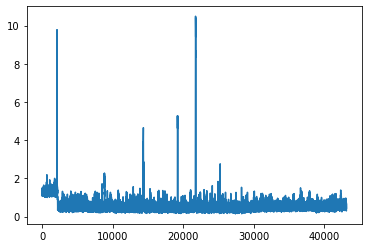

In [134]:
pd.Series(error_val).plot()

In [135]:
error_val[5000:].mean()

0.5212483998742685

In [136]:
test_val= val_csv[['time','attack']]

In [137]:
error_val

array([1.34211888, 1.11912063, 1.10244059, ..., 0.41170791, 0.58206649,
       0.69155332])

In [138]:
val_csv.shape

(43201, 81)

In [139]:
valid_idxs_val = [i+WINDOW_SIZE-1 for i in valid_idxs_val]
dist = pd.Series(error_val , index = valid_idxs_val)

ValueError: Length of passed values is 43111, index implies 43112.

In [140]:
test_val['dist'] = padding

ValueError: Length of values does not match length of index

In [141]:
test_val[['attack', 'dist']].boxplot(by= 'attack')

KeyError: "['dist'] not in index"

In [142]:
from sklearn.tree import DecisionTreeClassifier

In [143]:
dt = DecisionTreeClassifier(max_depth=10)

In [144]:
threshold = 0.52
test_val['dist'] =test_val['dist'] > threshold
test_val['dist'] = test_val['dist'].astype(int)

KeyError: 'dist'

In [145]:
from TaPR_pkg import etapr
TaPR = etapr.evaluate(anomalies=test_val['attack'].tolist(), predictions=test_val['dist'].tolist())
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

KeyError: 'dist'

In [146]:
dt.fit(abs(Y_val_hat - Y_val), test_val['attack'][-43111:])

ValueError: operands could not be broadcast together with shapes (43111,79) (43112,79) 

In [147]:
test_scaled = normalize(test_df.drop('time' , axis=1))
test_scaled = pd.DataFrame(test_scaled , columns=test_df.drop('time', axis=1).columns).ewm(alpha=0.9).mean()
test_scaled['time']= test_df['time'].tolist()
test_scaled['time']= pd.to_datetime(test_scaled['time'])

In [148]:
valid_idxs_test = []
timestamp_list = test_df['time'].astype(str).tolist()

for L in trange(len(timestamp_list) - WINDOW_SIZE + 1):
    R = L + WINDOW_SIZE - 1
    if dateutil.parser.parse(timestamp_list[R]) - dateutil.parser.parse(timestamp_list[L]) == timedelta(seconds=WINDOW_SIZE - 1):
        valid_idxs_test.append(L)

tag_values_test = np.array(test_scaled.drop('time',axis=1), dtype=np.float32)
data_list_test = []
for q in valid_idxs_test[:-1] :
    item = {} 
    last = q + WINDOW_SIZE 
    item["given"] = tag_values_test[q : last]
    item["answer"] = tag_values_test[last]
    data_list_test.append(item)

In [151]:

X_test =  np.array([i['given'] for i in data_list_test ])
Y_test = np.array([i['answer'] for i in data_list_test ])

X_test_reshape = X_test.reshape(len(X_test), 79*  WINDOW_SIZE)

In [152]:
Y_test_hat = []
for i in predictor :
    temp = i.predict(X_test_reshape)
    Y_test_hat.append(temp)

In [155]:
Y_test_hat = np.array(Y_test_hat).T
attack = dt.predict(abs(Y_test_hat - Y_test))
padding =[0]*WINDOW_SIZE 
padding.extend(attack)

NotFittedError: This DecisionTreeClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [156]:
len(padding)b

SyntaxError: invalid syntax (<ipython-input-156-0e8f2cf187e4>, line 1)

In [157]:
test_df.shape

(358804, 80)

In [158]:
submit = pd.read_csv('./HAI 2.0/sample_submission.csv')

In [159]:
submit.shape

(358804, 2)

In [160]:
submit["attack"] = padding
submit["attack"] = submit["attack"].astype(int)
submit.index = submit['time']
submit.to_csv('db_test_lgbm.csv', index=False)

ValueError: Length of values does not match length of index